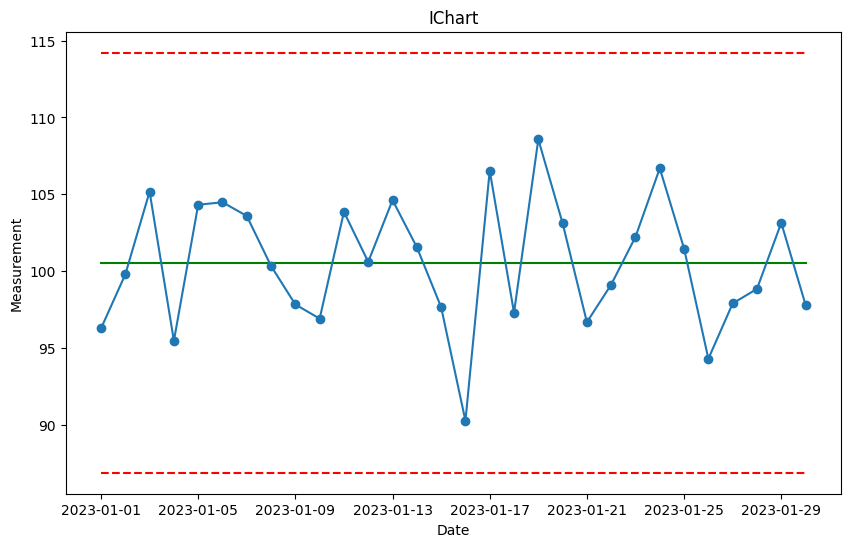

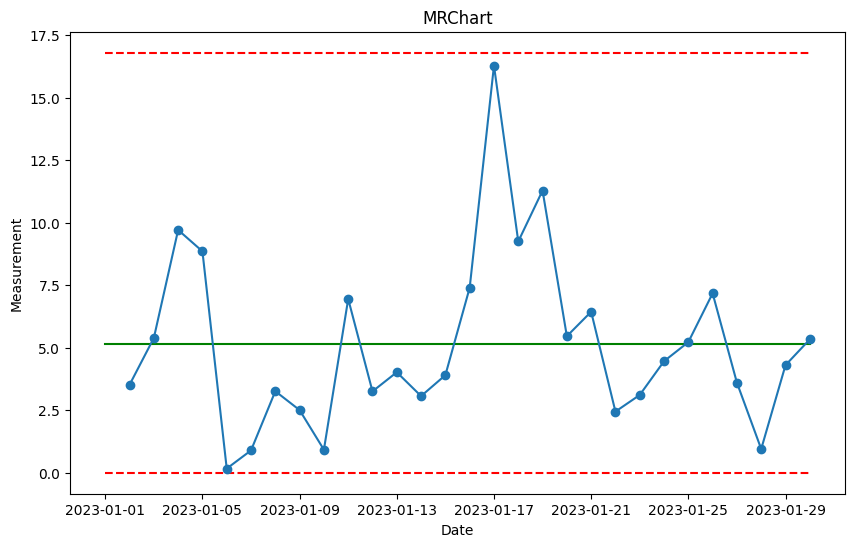

In [3]:
import pandas as pd
from spc_toolbox import IChart, MRChart

df = pd.read_csv("data/I-MRChart.csv")
df["Date"] = pd.to_datetime(df["Date"])

iChart = IChart()
mrChart = MRChart()

iChart.fit(index=df["Date"], values=df["Measurement"], n=2)
iChart.plot()

mrChart.fit(index=df["Date"], values=df["Measurement"], n=2)
mrChart.plot()

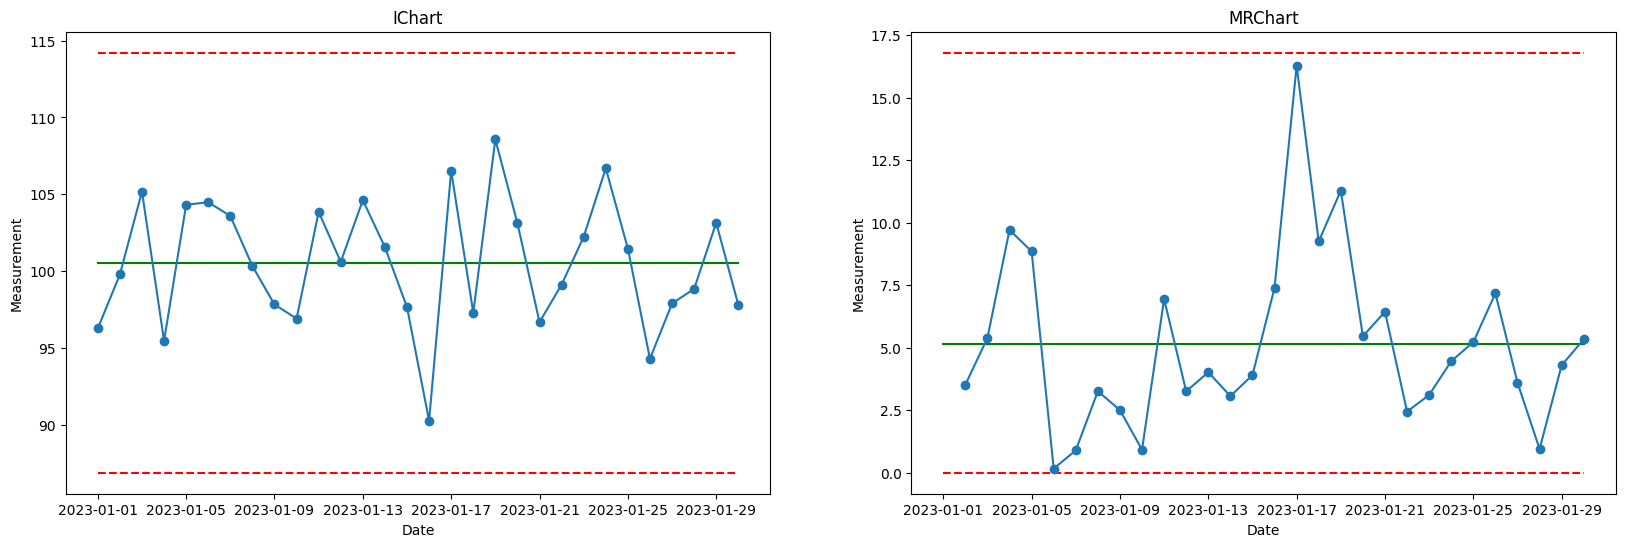

In [4]:
import pandas as pd
from spc_toolbox import IChart, MRChart

df = pd.read_csv("data/I-MRChart.csv")
df["Date"] = pd.to_datetime(df["Date"])

iChart = IChart()
mrChart = MRChart()

(iChart & mrChart).fit(index=df["Date"], values=df["Measurement"], n=2)
(iChart & mrChart).plot()

In [4]:
from spc_toolbox import ControlChart
import numpy as np
import pandas as pd
from spc_toolbox import IChart, MRChart

df = pd.read_csv("data/I-MRChart.csv")
df["Date"] = pd.to_datetime(df["Date"])

iChart = IChart()
mrChart = MRChart()

(iChart & mrChart).fit(index=df["Date"], values=df["Measurement"], n=2)

def rule_one_point_gt_k_sigma(chart: ControlChart, k: float) -> pd.Series:
    deviation = chart.y - chart.center_line
    return deviation.abs() > (chart.sigma * k)

def rule_k_points_same_side(chart: ControlChart, k: int) -> pd.Series:
    side = (chart.y > chart.center_line).astype(int)
    return side.rolling(window=k).sum().isin([0, k])

def rule_k_points_all_increasing_or_decreasing(chart: ControlChart, k: int) -> pd.Series:
    diff = chart.y.diff()
    increasing = (diff > 0).astype(int).rolling(window=k-1).sum() == (k-1)
    decreasing = (diff < 0).astype(int).rolling(window=k-1).sum() == (k-1)
    return increasing | decreasing

def rule_k_points_alternating(chart: ControlChart, k: int) -> pd.Series:
    diff = chart.y.diff().fillna(0)
    signs = diff.apply(np.sign)
    alternates = signs != signs.shift()
    return alternates.rolling(window=k).sum() == k

def rule_k_out_of_k1_points_2sigma(chart: ControlChart, k: int) -> pd.Series:
    deviation = chart.y - chart.center_line
    condition = deviation.abs() > (2 * chart.sigma)
    return condition.rolling(window=k+1).sum() >= k

def rule_k_out_of_k1_points_1sigma(chart: ControlChart, k: int) -> pd.Series:
    deviation = chart.y - chart.center_line
    condition = deviation.abs() > chart.sigma
    return condition.rolling(window=k+1).sum() >= k

def rule_k_points_within_1sigma(chart: ControlChart, k: int) -> pd.Series:
    deviation = chart.y - chart.center_line
    condition = deviation.abs() <= chart.sigma
    return condition.rolling(window=k).sum() == k

def rule_k_points_gt_1sigma(chart: ControlChart, k: int) -> pd.Series:
    deviation = chart.y - chart.center_line
    condition = deviation.abs() > chart.sigma
    return condition.rolling(window=k).sum() == k

rules = {
    "rule_one_point_gt_3_sigma": lambda chart: rule_one_point_gt_k_sigma(chart, 3),
    "rule_two_points_gt_2_sigma": lambda chart: rule_k_out_of_k1_points_2sigma(chart, 2),
    "rule_four_points_gt_1_sigma": lambda chart: rule_k_out_of_k1_points_1sigma(chart, 4),
    "rule_two_points_same_side": lambda chart: rule_k_points_same_side(chart, 2),
    "rule_five_points_increasing_or_decreasing": lambda chart: rule_k_points_all_increasing_or_decreasing(chart, 5),
    "rule_two_points_alternating": lambda chart: rule_k_points_alternating(chart, 2),
    "rule_eight_points_in_a_row_on_the_same_side_of_center_line": lambda chart: rule_k_points_same_side(chart, 8),
    "rule_six_points_in_a_row_continuously_increasing_or_decreasing": lambda chart: rule_k_points_all_increasing_or_decreasing(chart, 6),
    "rule_fourteen_points_in_a_row_alternating_up_and_down": lambda chart: rule_k_points_alternating(chart, 14),
    "rule_fifteen_points_in_a_row_within_1_sigma": lambda chart: rule_k_points_within_1sigma(chart, 15),
    "rule_eight_points_in_a_row_outside_1_sigma": lambda chart: rule_k_points_gt_1sigma(chart, 8)
}

results = (iChart & mrChart).evaluate_rules(rules)
results_df = pd.concat((pd.DataFrame(v) for v in results.values()), axis=1, keys=list(results.keys()))
results_df

IChart                             \
   rule_one_point_gt_3_sigma rule_two_points_gt_2_sigma   
0                      False                      False   
1                      False                      False   
2                      False                      False   
3                      False                      False   
4                      False                      False   
5                      False                      False   
6                      False                      False   
7                      False                      False   
8                      False                      False   
9                      False                      False   
10                     False                      False   
11                     False                      False   
12                     False                      False   
13                     False                      False   
14                     False                      False   
15                     False                      False   
16                     False                      False   
17                     False                      False   
18                     False                      False   
19                     False                      False   
20                     False                      False   
21                     False                      False   
22                     False                      False   
23                     False                      False   
24                     False                      False   
25                     False                      False   
26                     False                      False   
27                     False                      False   
28                     False                      False   
29                     False                      False   

                                                          \
   rule_four_points_gt_1_sigma rule_two_points_same_side   
0                        False                     False   
1                        False                      True   
2                        False                     False   
3                        False                     False   
4                        False                     False   
5                        False                      True   
6                        False                      True   
7                        False                     False   
8                        False                      True   
9                        False                      True   
10                       False                     False   
11                       False                      True   
12                       False                      True   
13                       False                      True   
14                       False                     False   
15                       False                      True   
16                       False                     False   
17                       False                     False   
18                       False                     False   
19                       False                      True   
20                       False                     False   
21                       False                      True   
22                       False                     False   
23                       False                      True   
24                       False                      True   
25                       False                     False   
26                       False                      True   
27                       False                      True   
28                       False                     False   
29                       False                     False   

                                                                          \
   rule_five_points_increasing_or_decreasing rule_two_points_alternating   
0                                      False                